# Tarea 1: Algoritmo FP-Growth
<hr/>

### Nombre: Benjamín Farías V.

## Librerías

A continuación se importan las librerías necesarias para la tarea:

In [85]:
# Se importan las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Cargar Base de Datos

Aquí se carga la base de datos, con la opción de limitar la cantidad de filas para obtener un mejor rendimiento. Además se pueden descomentar los ejemplos de abajo para probar el algoritmo con bases de datos más simples:

In [86]:
# Se carga la base de datos, con la opción de limitar la cantidad de tuplas a analizar para una ejecución más rápida
def load_database(path, limit):
    db = np.load(path, allow_pickle=True).item()
    new_db = [set(db[x]) for x in db if x <= limit]
    return new_db

filtered = load_database('spotify.npy', float('inf'))

# Ejemplos de prueba

#filtered = [set(list('MONKEY')), set(list('DONKEY')), set(list('MAKE')), set(list('MUCKY')), set(list('COOKIE'))]
#filtered = [set(list('ABDE')), set(list('BCE')), set(list('ABDE')), set(list('ABCE')), set(list('ABCDE')), set(list('BCD'))]
#filtered = [set(list('125')), set(list('24')), set(list('23')), set(list('124')), set(list('13')), set(list('23')), 
#            set(list('13')), set(list('1235')), set(list('123'))]
#filtered = [set(list('EADB')), set(list('DACEB')), set(list('CABE')), set(list('BAD')), set(list('D')), set(list('DB')), 
#            set(list('ADE')), set(list('BC'))]

## Algoritmo

Se aplica el algoritmo a la base de datos mediante la función fit( ), que a su vez utiliza una variedad de funciones auxiliares para organizar mejor el código:

In [87]:
# Se obtienen los items frecuentes de la base de datos (considerando el support elegido)
def find_frequent(db, items, support):
    counter = {x: 0 for x in items}
    for playlist in db:
        for song in playlist:
            counter[song] += 1
    return {x: counter[x] for x in counter if counter[x] >= support}


# Se filtran todas las filas de la base de datos, dejando sólo los items frecuentes 
# de cada playlist (ordenados según frecuencia)
def sort_itemsets(db, frequent):
    itemsets = []
    for playlist in db:
        ordered_itemset = [item for item in frequent if item in playlist]
        if ordered_itemset:
            itemsets.append(ordered_itemset)
    return itemsets


# Se añade una rama al árbol, representando un itemset de elementos frecuentes
def add_branch(tree, branch, _id):
    current = 0
    for node in branch:
        children = tree[current]['children']
        if node in children:
            tree[children[node]]['count'] += 1
        else:
            children[node] = _id
            tree[_id] = {'value': node, 'count': 1, 'children': {}, 'parent': current}
            _id += 1
        current = children[node]
    return _id


# Se genera el FP Tree, a partir de los itemsets de elementos frecuentes 
# obtenidos en cada fila de la base de datos
def generate_tree(branches):
    """
    Cada nodo tiene un valor (canción), contador de ocurrencias, 
    diccionario de hijos y referencia al padre
    """
    fp_tree = {0: {'value': None, 'count': 1, 'children': {}, 'parent': None}} 
    _id = 1
    for branch in branches:
        _id = add_branch(fp_tree, branch, _id)
    return fp_tree


# Se obtiene el camino desde la raíz del FP Tree hasta un nodo en específico, 
# utilizando su atributo parent para recorrer el árbol desde abajo hacia arriba
def get_path(node, tree):
    path = []
    current = tree[node]
    while current['parent']:
        parent = tree[current['parent']]
        path.insert(0, parent['value'])
        current = parent
    return path


# Se obtiene la Conditional Pattern Base de cada uno de los items frecuentes, utilizando el FP Tree
def find_conditionals(fp_tree, frequent_set):
    conditional_pb = {x: {} for x in frequent_set}
    for node in [x for x in fp_tree if fp_tree[x]['value'] in frequent_set]:
        path = get_path(node, fp_tree)
        if path:
            conditional_pb[fp_tree[node]['value']][tuple(path)] = fp_tree[node]['count']
    return conditional_pb


# Se forman las ramas del Conditional FP Tree a partir de las Conditional Pattern Base, 
# eliminando los items que no cumplen con el support
def conditional_tree(conditionals, support):
    cfp_tree = {x: {} for x in conditionals}
    for item in conditionals:
        item_count = {x: 0 for x in conditionals}
        cp_base = [list(x) for x in conditionals[item]]
        for branch in cp_base:
            for node in branch:
                item_count[node] += conditionals[item][tuple(branch)]
        """
        Aquí se filtran las sub-ramas que no cumplen con el support, eliminando además las que quedan vacías
        """
        f_list = [x for x in item_count if item_count[x] >= support]
        for branch in cp_base:
            count = conditionals[item][tuple(branch)]
            new_branch = tuple([x for x in branch if x in f_list])
            if new_branch not in cfp_tree[item] and new_branch:
                cfp_tree[item][new_branch] = count
            elif new_branch:
                cfp_tree[item][new_branch] += count
    return {x: cfp_tree[x] for x in cfp_tree if cfp_tree[x]}


# Se genera el conjunto potencia de una lista de items (todas las combinaciones posibles entre ellos)
def combine(items, length):
    for i in range(2**length):
        comb = []
        for j in range(length):
            if (i >> j) % 2 == 1:
                comb.append(items[j])
        yield comb


# Se generan todas las combinaciones a partir de una rama del Conditional FP Tree, 
# obteniendo así sus Frequent Patterns asociados
def generate_combinations(item, condition, count, f_patterns):
    combos = list(combine(list(condition), len(condition)))[1:] # Se omite la combinación nula (conjunto vacío)
    for c in combos:
        c.append(item)
        combination = tuple(c)
        if combination not in f_patterns:
            f_patterns[combination] = 0
        f_patterns[combination] += count


# Se generan todos los Frequent Patterns a partir del Conditional FP Tree, 
# dejando finalmente los que cumplen con el support
def generate_fp(cfp_tree, support):
    new_patterns = {x: {} for x in cfp_tree}
    for item in cfp_tree:
        f_patterns = {}
        for condition, count in cfp_tree[item].items():
            generate_combinations(item, condition, count, f_patterns)
        new_patterns[item] = {x: f_patterns[x] for x in f_patterns if f_patterns[x] >= support}
    return new_patterns


# Función que aplica el algoritmo a la base de datos, retornando los itemsets frecuentes
def fit(db, support):
    items = set()
    for playlist in db: # Se obtienen todos los items de la base de datos
        items |= playlist
    frequent = find_frequent(db, items, support) # Se obtienen los items frecuentes
    frequent_set = sorted([song for song in frequent], key=frequent.get, reverse=True)
    branches = sort_itemsets(db, frequent_set) # Se filtran las filas según los items frecuentes
    fp_tree = generate_tree(branches) # Se genera el FP Tree
    conditionals = find_conditionals(fp_tree, frequent_set) # Se encuentran los Conditional Pattern Base
    cfp_tree = conditional_tree(conditionals, support) # Se generan los Conditional FP Trees
    frequent_patterns = generate_fp(cfp_tree, support).values() # Se generan los itemsets frecuentes
    result = {} # Se juntan los resultados
    for pattern in frequent_patterns:
        for k, v in pattern.items():
            result[k] = v
    for fp in frequent:
        result[tuple([fp])] = frequent[fp]
    return {x: result[x] for x in sorted(result, key=lambda x: result[x])}


frequent_itemsets = fit(filtered, 100) # Itemsets Frecuentes (se recomienda usar support 100 o mayor para la bdd completa)

## Reglas de Asociación

Se utiliza la función generate( ) para encontrar todas las reglas de asociación a partir de los itemsets frecuentes. También se da la opción de filtrar dichas reglas según support, confidence, lift (vistas en clase) y adicionalmente según:

Conviction: Indica qué tan probable es que una asociación haya ocurrido solamente por azar, sin tener mucha relación entre sus items (a medida que aumenta la Conviction es más probable que la regla sólo haya ocurrido por azar).

RPF (Rule Power Factor): Indica la intensidad con la que están asociados los items de una regla (a medida que aumenta el RPF los items están más relacionados entre sí).

In [88]:
# Función que genera las reglas de asociación a partir de los itemsets frecuentes y las métricas seleccionadas
def generate(db, itemsets, min_support=0, min_confidence=0, min_lift=1, max_conviction=float('inf'), min_rpf=0):
    total = len(db) # Cantidad de filas de la base de datos
    rules = {'Frequent Pattern': [], 'Support': [], 'Confidence': [], 'Lift': [], 'Conviction': [], 'RPF': []} # Reglas
    frozen_itemsets = {frozenset(x): itemsets[x] for x in itemsets} # Itemsets frecuentes y sus ocurrencias en la base de datos
    for itemset in {x for x in frozen_itemsets if len(x) > 1}: # Itemsets que sirven para obtener relaciones
        count = frozen_itemsets[itemset]
        support = count / total # Support
        """
        Se generan las combinaciones posibles entre los elementos de un itemset
        """
        for c in list(combine(list(itemset), len(itemset)))[1:-1]:
            cause = set(c)                    # Antecedente
            effect = set(itemset) - cause     # Consecuente
            confidence = count / frozen_itemsets[frozenset(cause)] # Confidence
            lift = (confidence * total) / frozen_itemsets[frozenset(effect)] # Lift
            if confidence != 1:
                conviction = (1 - (frozen_itemsets[frozenset(effect)] / total)) / (1 - confidence) # Conviction
            else:
                conviction = (1 - (frozen_itemsets[frozenset(effect)] / total)) / 0.00001 # Si la confianza es 1
            rpf = (confidence * count) / total # RPF
            if (support >= min_support) and (confidence >= min_confidence) and (lift >= min_lift) and \
                (conviction <= max_conviction) and (rpf >= min_rpf): # Se filtran según métricas
                s_cause = ', '.join(cause)
                s_effect = ', '.join(effect)
                rules['Frequent Pattern'].append(f'{s_cause} => {s_effect}')
                rules['Support'].append(support)
                rules['Confidence'].append(confidence)
                rules['Lift'].append(lift)
                rules['Conviction'].append(conviction)
                rules['RPF'].append(rpf)
    return rules

sample = generate(filtered, frequent_itemsets) # Todas las reglas encontradas
df = pd.DataFrame(sample)
df.style.set_properties(**{'text-align': 'center'})

## Análisis de las Reglas

### Criterios de Calidad Propuestos

En el 1er criterio se buscarán reglas que tengan un Lift ALTO y una Conviction BAJA, de manera que se encuentren relaciones que probablemente NO ocurrieron por azar, sino que sus items están realmente asociados entre sí:

In [89]:
first_criterion = generate(filtered, frequent_itemsets, min_lift=10, max_conviction=1.3)
df = pd.DataFrame(first_criterion)
df.sort_values(['Lift', 'Conviction'], ascending=[False, True])
df.style.set_properties(**{'text-align': 'center'})
df.head(10)

,Frequent Pattern,Support,Confidence,Lift,Conviction,RPF
0,"HUMBLE. => goosebumps, XO TOUR Llif3",0.0111,0.238710,15.704584,1.293593,0.002650
1,"HUMBLE. => Tunnel Vision, XO TOUR Llif3",0.0102,0.219355,16.129032,1.263570,0.002237
2,"HUMBLE. => Mask Off, DNA.",0.0100,0.215054,19.550342,1.259959,0.002151
3,"HUMBLE. => Mask Off, iSpy (feat. Lil Yachty)",0.0101,0.217204,14.775803,1.258694,0.002194
4,"HUMBLE. => Mask Off, Bad and Boujee (feat. Lil...",0.0110,0.236559,15.666168,1.290080,0.002602
5,"HUMBLE. => goosebumps, Congratulations",0.0112,0.240860,15.539369,1.296863,0.002698
6,HUMBLE. => Swang,0.0113,0.243011,11.096381,1.292092,0.002746
7,"HUMBLE. => Mask Off, Bounce Back",0.0101,0.217204,15.970904,1.260099,0.002194
8,"HUMBLE. => Slippery (feat. Gucci Mane), XO TOU...",0.0101,0.217204,16.454871,1.260610,0.002194
9,"HUMBLE. => XO TOUR Llif3, DNA.",0.0102,0.219355,18.589393,1.265876,0.002237


En el 2do criterio se buscarán reglas que tengan Confidence ALTA y un RPF ALTO, para así encontrar relaciones que representen a items que la mayoría de las veces se encuentran juntos:

In [90]:
second_criterion = generate(filtered, frequent_itemsets, min_confidence=0.7, min_rpf=0.008)
df = pd.DataFrame(second_criterion)
df.sort_values(['Confidence', 'RPF'], ascending=[False, False])
df.style.set_properties(**{'text-align': 'center'})
df.head(10)

,Frequent Pattern,Support,Confidence,Lift,Conviction,RPF
0,"goosebumps, XO TOUR Llif3 => HUMBLE.",0.0111,0.730263,15.704584,3.534927,0.008106
1,"Mask Off, DNA. => HUMBLE.",0.0100,0.909091,19.550342,10.488500,0.009091
2,"XO TOUR Llif3, Congratulations => HUMBLE.",0.0128,0.715084,15.378146,3.346598,0.009153
3,"Mask Off, Bad and Boujee (feat. Lil Uzi Vert) ...",0.0110,0.728477,15.666168,3.511671,0.008013
4,"goosebumps, Congratulations => HUMBLE.",0.0112,0.722581,15.539369,3.437035,0.008093
5,"XO TOUR Llif3, DNA. => HUMBLE.",0.0102,0.864407,18.589393,7.032063,0.008817
6,"Mask Off, Congratulations => HUMBLE.",0.0121,0.746914,16.062658,3.767488,0.009038
7,"Mask Off, goosebumps => HUMBLE.",0.0110,0.743243,15.983726,3.713632,0.008176
8,"Mask Off, XO TOUR Llif3 => HUMBLE.",0.0131,0.803681,17.283462,4.856891,0.010528
9,DNA. => HUMBLE.,0.0190,0.822511,17.688405,5.372159,0.015628


En el 3er criterio se buscarán reglas que tengan Confidence ALTA y un Lift ALTO, para así encontrar relaciones que impliquen que al tener ciertos items antecedentes mejore la probabilidad de tener a los items consecuentes:

In [91]:
third_criterion = generate(filtered, frequent_itemsets, min_confidence=0.7, min_lift=15)
df = pd.DataFrame(third_criterion)
df.sort_values(['Confidence', 'Lift'], ascending=[False, False])
df.style.set_properties(**{'text-align': 'center'})
df.head(10)

,Frequent Pattern,Support,Confidence,Lift,Conviction,RPF
0,"goosebumps, XO TOUR Llif3 => HUMBLE.",0.0111,0.730263,15.704584,3.534927,0.008106
1,"Tunnel Vision, XO TOUR Llif3 => HUMBLE.",0.0102,0.750000,16.129032,3.814000,0.007650
2,"Tunnel Vision, HUMBLE. => XO TOUR Llif3",0.0102,0.733813,22.718667,3.635414,0.007485
3,"Mask Off, DNA. => HUMBLE.",0.0100,0.909091,19.550342,10.488500,0.009091
4,"XO TOUR Llif3, Congratulations => HUMBLE.",0.0128,0.715084,15.378146,3.346598,0.009153
5,"Mask Off, Bad and Boujee (feat. Lil Uzi Vert) ...",0.0110,0.728477,15.666168,3.511671,0.008013
6,"goosebumps, Congratulations => HUMBLE.",0.0112,0.722581,15.539369,3.437035,0.008093
7,"Mask Off, Bounce Back => HUMBLE.",0.0101,0.742647,15.970904,3.705029,0.007501
8,"Slippery (feat. Gucci Mane), XO TOUR Llif3 => ...",0.0101,0.765152,16.454871,4.060065,0.007728
9,"Broccoli (feat. Lil Yachty), Bounce Back => Ba...",0.0100,0.775194,22.469385,4.294810,0.007752


Finalmente se buscarán reglas que tengan la combinación más equilibrada entre todas las métricas, para así encontrar relaciones que sean representativas bajo distintos puntos de vista:

In [92]:
final_criterion = generate(filtered, frequent_itemsets, min_support=0.01, min_confidence=0.5, min_lift=15, 
                           max_conviction=2, min_rpf=0.005)
df = pd.DataFrame(final_criterion)
df.sort_values(['Support', 'Confidence', 'Lift', 'Conviction', 'RPF'], ascending=[False, False, False, True, False])
df.style.set_properties(**{'text-align': 'center'})
df.head(10)

,Frequent Pattern,Support,Confidence,Lift,Conviction,RPF
0,"HUMBLE., XO TOUR Llif3 => Tunnel Vision",0.0102,0.500000,20.242915,1.950600,0.005100
1,Swang => XO TOUR Llif3,0.0113,0.515982,15.974667,1.999305,0.005831
2,"HUMBLE., XO TOUR Llif3 => DNA.",0.0102,0.500000,21.645022,1.953800,0.005100
3,Tunnel Vision => Mask Off,0.0127,0.514170,16.271204,1.993290,0.006530
4,679 (feat. Remy Boyz) => Trap Queen,0.0122,0.500000,17.301038,1.942200,0.006100
5,Chicken Fried => Knee Deep (feat. Jimmy Buffett),0.0107,0.500000,31.847134,1.968600,0.005350
6,Mask Off => XO TOUR Llif3,0.0163,0.515823,15.969746,1.998648,0.008408
7,XO TOUR Llif3 => Mask Off,0.0163,0.504644,15.969746,1.954958,0.008226
8,Swang => Mask Off,0.0112,0.511416,16.184036,1.982052,0.005728
9,X (feat. Future) => No Heart,0.0103,0.504902,34.114997,1.989909,0.005200


### Comparación de Reglas

A continuación se comparan las 4 primeras reglas obtenidas (sin ningún criterio en particular):

In [93]:
rules = generate(filtered, frequent_itemsets)
df = pd.DataFrame(rules)
df.style.set_properties(**{'text-align': 'center'})
df.head(4)

,Frequent Pattern,Support,Confidence,Lift,Conviction,RPF
0,Closer => Broccoli (feat. Lil Yachty),0.0107,0.147994,3.709135,1.126871,0.001584
1,Broccoli (feat. Lil Yachty) => Closer,0.0107,0.268170,3.709135,1.267645,0.002869
2,Broccoli (feat. Lil Yachty) => Bounce Back,0.0129,0.323308,10.885800,1.433888,0.004171
3,Bounce Back => Broccoli (feat. Lil Yachty),0.0129,0.434343,10.885800,1.697320,0.005603


En las primeras 2 reglas podemos observar que representan a los mismos items, sólo que el antecedente y consecuente están al revés. Comparando sus métricas se puede ver que la segunda tiene una mayor confianza y RPF, por lo que es de mejor calidad que la primera. En las últimas 2 reglas ocurre lo mismo, la segunda es mejor que la primera.

Al comparar las 4 reglas, se puede ver que en la mayoría de las métricas son similares, excepto en Lift, que claramente indica que las primeras 2 reglas no son de mucha utilidad real, mientras que las últimas 2 sí lo son (al estar juntos los items aumenta la probabilidad de que aparezcan).

De esto tenemos que la mejor la regla a sacar de este conjunto corresponde a la última, mientras que las otras 3 pueden ser ignoradas sin perder mucha información de utilidad para el análisis posterior.

En el siguiente gráfico se puede visualizar cómo aumenta la Conviction a medida que aumentan la Confidence y el Lift, donde sólo unas pocas reglas se mantienen con Conviction baja:

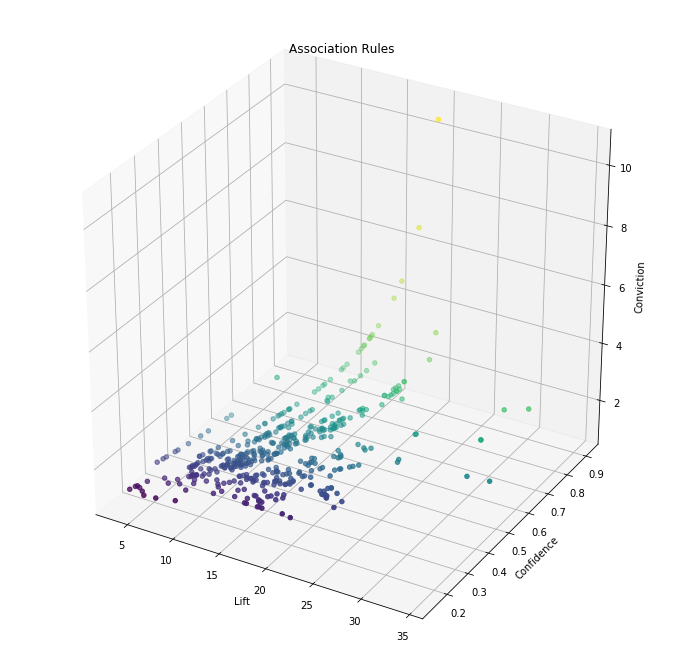

In [94]:
plot_3d = plt.figure(figsize=(12, 12)).gca(projection='3d')
plt.title('Association Rules')
plot_3d.scatter(df['Lift'], df['Confidence'], df['Conviction'], c=df['Confidence'])
plot_3d.set_xlabel('Lift')
plot_3d.set_ylabel('Confidence')
plot_3d.set_zlabel('Conviction')
plt.show()

Finalmente, se puede concluir que las mejores reglas son aquellas que quedaron en la esquina superior izquierda de la base del gráfico, aportando en Confidence y Lift sin aumentar mucho la Conviction.